# Pyserini Demo on COVID-19 Dataset (Title + Abstract Index) with HuggingFace Transformers based visualization


This notebook is a based on the original pyserini notebook but adds a sciBERT model that is fine-tuned on the CORD-19 dataset. The model is used for question answering on top of the retrieved (relevant) documents.

This notebook provides a demo on how to get started in searching the [COVID-19 Open Research Dataset](https://pages.semanticscholar.org/coronavirus-research) (release of 2020/03/20) from AI2.
In this notebook, we'll be working with the title + abstract index. 
Specifically, we're not indexing the full text (that'll come later, soon!).


In [ ]:
from IPython.core.display import display, HTML

First, install a proper java version (11) to make pyserini happy. (https://github.com/castorini/anserini/issues/832)

In [ ]:
%%capture

!wget "https://download.java.net/java/GA/jdk11/9/GPL/openjdk-11.0.2_linux-x64_bin.tar.gz"
!tar -xvf openjdk-11.0.2_linux-x64_bin.tar.gz

!export JAVA_HOME='/kaggle/working/jdk-11.0.2/'
!export PATH='/kaggle/working/jdk-11.0.2/bin':$PATH

Pyserini needs java - it comes with the anserini jar bundled. Try using at least Java 11, otherwise there is a known issue that may cause problems - https://github.com/castorini/pyserini#known-issues.

In [ ]:
# %%capture
!mkdir -p /kaggle/working/jdk-11.0.2/jre/lib/amd64/server/
!ln -s /kaggle/working/jdk-11.0.2/lib/server/libjvm.so /kaggle/working/jdk-11.0.2/jre/lib/amd64/server/libjvm.so

In [ ]:
# !ls -la /kaggle/working/jdk-11.0.2/lib/server/
# !ls -la /kaggle/working/jdk-11.0.2/jre/lib/amd64/server/

In [ ]:
import json
import os

# linux
os.environ["JAVA_HOME"] = "/kaggle/working/jdk-11.0.2/"

Next, install Python dependencies

In [ ]:
%%capture
!pip install pyserini==0.8.1.0
!pip install transformers

Let's grab the pre-built index:

In [ ]:
%%capture
!wget https://www.dropbox.com/s/j1epbu4ufunbbzv/lucene-index-covid-2020-03-27.tar.gz
!tar xvfz lucene-index-covid-2020-03-27.tar.gz

Sanity check of index size (should be 1.3G):

In [ ]:
!du -h lucene-index-covid-2020-03-27

In [ ]:
import torch
import numpy
from tqdm import tqdm
from transformers import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Let's load BioBERT (https://arxiv.org/abs/1901.08746) from HuggingFace Transformers

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed', do_lower_case=False)
# model = AutoModel.from_pretrained('monologg/biobert_v1.1_pubmed')

Instead, load fine-tuned SciBERT from a local directory. The model was fine-tuned on the dataset from the CORD-19 challenge and saved.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('../input/scibertcord19checkpoint950000/checkpoint-950000', do_lower_case=False)
model = AutoModel.from_pretrained('../input/scibertcord19checkpoint950000/checkpoint-950000')

You can use `pysearch` to search over an index. Here's the basic usage:

In [ ]:
COVID_INDEX = 'lucene-index-covid-2020-03-27/'

def show_query(query):
    """HTML print format for the searched query"""
    return HTML('<br/><div style="font-family: Times New Roman; font-size: 20px;'
                'padding-bottom:12px"><b>Query</b>: '+query+'</div>')

def show_document(idx, doc):
    """HTML print format for document fields"""
    have_body_text = 'body_text' in json.loads(doc.raw)
    body_text = ' Full text available.' if have_body_text else ''
    return HTML('<div style="font-family: Times New Roman; font-size: 18px; padding-bottom:10px">' + 
               f'<b>Document {idx}:</b> {doc.docid} ({doc.score:1.2f}) -- ' +
               f'{doc.lucene_document.get("authors")} et al. ' +
             # f'{doc.lucene_document.get("journal")}. ' +
             # f'{doc.lucene_document.get("publish_time")}. ' +
               f'{doc.lucene_document.get("title")}. ' +
               f'<a href="https://doi.org/{doc.lucene_document.get("doi")}">{doc.lucene_document.get("doi")}</a>.'
               + f'{body_text}</div>')

def show_query_results(query, searcher, top_k=10):
    """HTML print format for the searched query"""
    hits = searcher.search(query)
    display(show_query(query))
    for i, hit in enumerate(hits[:top_k]):
        display(show_document(i+1, hit))
    return hits[:top_k]   

In [ ]:
from pyserini.search import pysearch

searcher = pysearch.SimpleSearcher(COVID_INDEX)
query = ('these differences reside in the molecular structure of spike proteins and some other factors. Which receptor combination(s) will cause maximum harm')
hits = show_query_results(query, searcher, top_k=10)

From the hits array, use `.lucene_document` to access the underlying indexed Lucene `Document`, and from there, call `.get(field)` to fetch specific fields, like "title", "doc", etc.
The complete list of available fields is [here](https://github.com/castorini/anserini/blob/master/src/main/java/io/anserini/index/generator/CovidGenerator.java#L46).

Let's extract contextualized vectors of queries and abstracts from SciBERT for highlighting relevant paragraphs.

First, extract the contextualized vectors of the query above:

$$q_1, \ldots, q_T = \text{SciBERT}(\text{query})$$

In [ ]:
def extract_scibert(text, tokenizer, model):
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0])[1:-1]

    n_chunks = int(numpy.ceil(float(text_ids.size(1))/510))
    states = []
    
    for ci in range(n_chunks):
        text_ids_ = text_ids[0, 1+ci*510:1+(ci+1)*510]            
        text_ids_ = torch.cat([text_ids[0, 0].unsqueeze(0), text_ids_])
        if text_ids[0, -1] != text_ids[0, -1]:
            text_ids_ = torch.cat([text_ids_, text_ids[0,-1].unsqueeze(0)])
        
        with torch.no_grad():
            state = model(text_ids_.unsqueeze(0))[0]
            state = state[:, 1:-1, :]
        states.append(state)

    state = torch.cat(states, axis=1)
    return text_ids, text_words, state[0]

In [ ]:
query_ids, query_words, query_state = extract_scibert(query, tokenizer, model)

Second, let's extract contextualized vectors of all the paragraphs from the hit #7:

$$p_1^k, \ldots, p_{T_k}^k = \text{SciBERT}(\text{paragraph}^k)$$

In [ ]:
ii = 0
doc_json = json.loads(hits[ii].raw)

paragraph_states = []
for par in tqdm(doc_json['body_text']):
    state = extract_scibert(par['text'], tokenizer, model)
    paragraph_states.append(state)

We then compute the cosine similarity matrix between the query and each paragraph:

$$A^k = [a^k_{ij}] \in \mathbb{R}^{|\text{query}| \times |\text{paragraph}^k|},$$

where

$$a^k_{ij} = \frac{q_i^\top p_j^k}{\| q_i \| \| p_j^k \|}$$


In [ ]:
def cross_match(state1, state2):
    state1 = state1 / torch.sqrt((state1 ** 2).sum(1, keepdims=True))
    state2 = state2 / torch.sqrt((state2 ** 2).sum(1, keepdims=True))
    sim = (state1.unsqueeze(1) * state2.unsqueeze(0)).sum(-1)
    return sim

In [ ]:
sim_matrices = []
for pid, par in tqdm(enumerate(doc_json['body_text'])):
    sim_score = cross_match(query_state, paragraph_states[pid][-1])
    sim_matrices.append(sim_score)

Let's retrieve the most relevant paragraphs first, where define the top-$M$ most relevant paragraphs as 

$$\arg\text{top-$M$}_{k=1}^K \max_{i=1,\ldots,|\text{query}|} \max_{j=1,\ldots, |\text{paragraph}^k|} A_{ij}^k$$

that is, a paragraph with the highly matched words to the query words is considered relevant.

In [ ]:
paragraph_relevance = [torch.max(sim).item() for sim in sim_matrices]

# Select the index of top 5 paragraphs with highest relevance
rel_index = numpy.argsort(paragraph_relevance)[-5:][::-1]

In [ ]:
def show_sections(section, text):
    """HTML print format for document subsections"""
    return HTML('<div style="font-family: Times New Roman; font-size: 18px; padding-bottom:10px; margin-left: 15px">' + 
        f'<b>{section}</b> -- {text.replace(" ##","")} </div>')

display(show_query(query))
display(show_document(ii, hits[ii]))
for ri in numpy.sort(rel_index):
    display(show_sections(doc_json["body_text"][ri]['section'], " ".join(paragraph_states[ri][1])))

We want to look at more details by highlighting relevant phrases in each paragraph, where we define relevant phrases for each paragraph as

$$\arg\text{top-$M$}_{j=1,\ldots, |\text{paragraph}^k|} \max_{i=1,\ldots,|\text{query}|} A_{ij}^k$$

that is, any word that had a high similarity to each of the query words is considered relevant. given these words, we highlight a window of 10 surrounding each of them.

In [ ]:
def highlight_paragraph(ptext, rel_words, max_win=10):
    para = ""
    prev_idx = 0
    for jj in rel_words:
        
        if prev_idx > jj:
            continue
        
        found_start = False
        for kk in range(jj, prev_idx-1, -1):
            if ptext[kk] == "." and (ptext[kk+1][0].isupper() or ptext[kk+1][0] == '['):
                sent_start = kk
                found_start = True
                break
        if not found_start:
            sent_start = prev_idx-1
            
        found_end = False
        for kk in range(jj, len(ptext)-1):
            if ptext[kk] == "." and (ptext[kk+1][0].isupper() or ptext[kk+1][0] == '['):
                sent_end = kk
                found_end = True
                break
                
        if not found_end:
            if kk >= len(ptext) - 2:
                sent_end = len(ptext)
            else:
                sent_end = jj
        
        para = para + " "
        para = para + " ".join(ptext[prev_idx:sent_start+1])
        para = para + " <font color='blue'>"
        para = para + " ".join(ptext[sent_start+1:sent_end])
        para = para + "</font> "
        prev_idx = sent_end
        
    if prev_idx < len(ptext):
        para = para + " ".join(ptext[prev_idx:])

    return para

In [ ]:
display(show_query(query))

display(show_document(ii, hits[ii]))

for ri in numpy.sort(rel_index):
    sim = sim_matrices[ri].data.numpy()
    
    # Select the two highest scoring words in the paragraph
    rel_words = numpy.sort(numpy.argsort(sim.max(0))[-2:][::-1])
    p_tokens = paragraph_states[ri][1]
    para = highlight_paragraph(p_tokens, rel_words)
    display(show_sections(doc_json["body_text"][ri]['section'], para))

---

## Diagram of contribution

<!-- 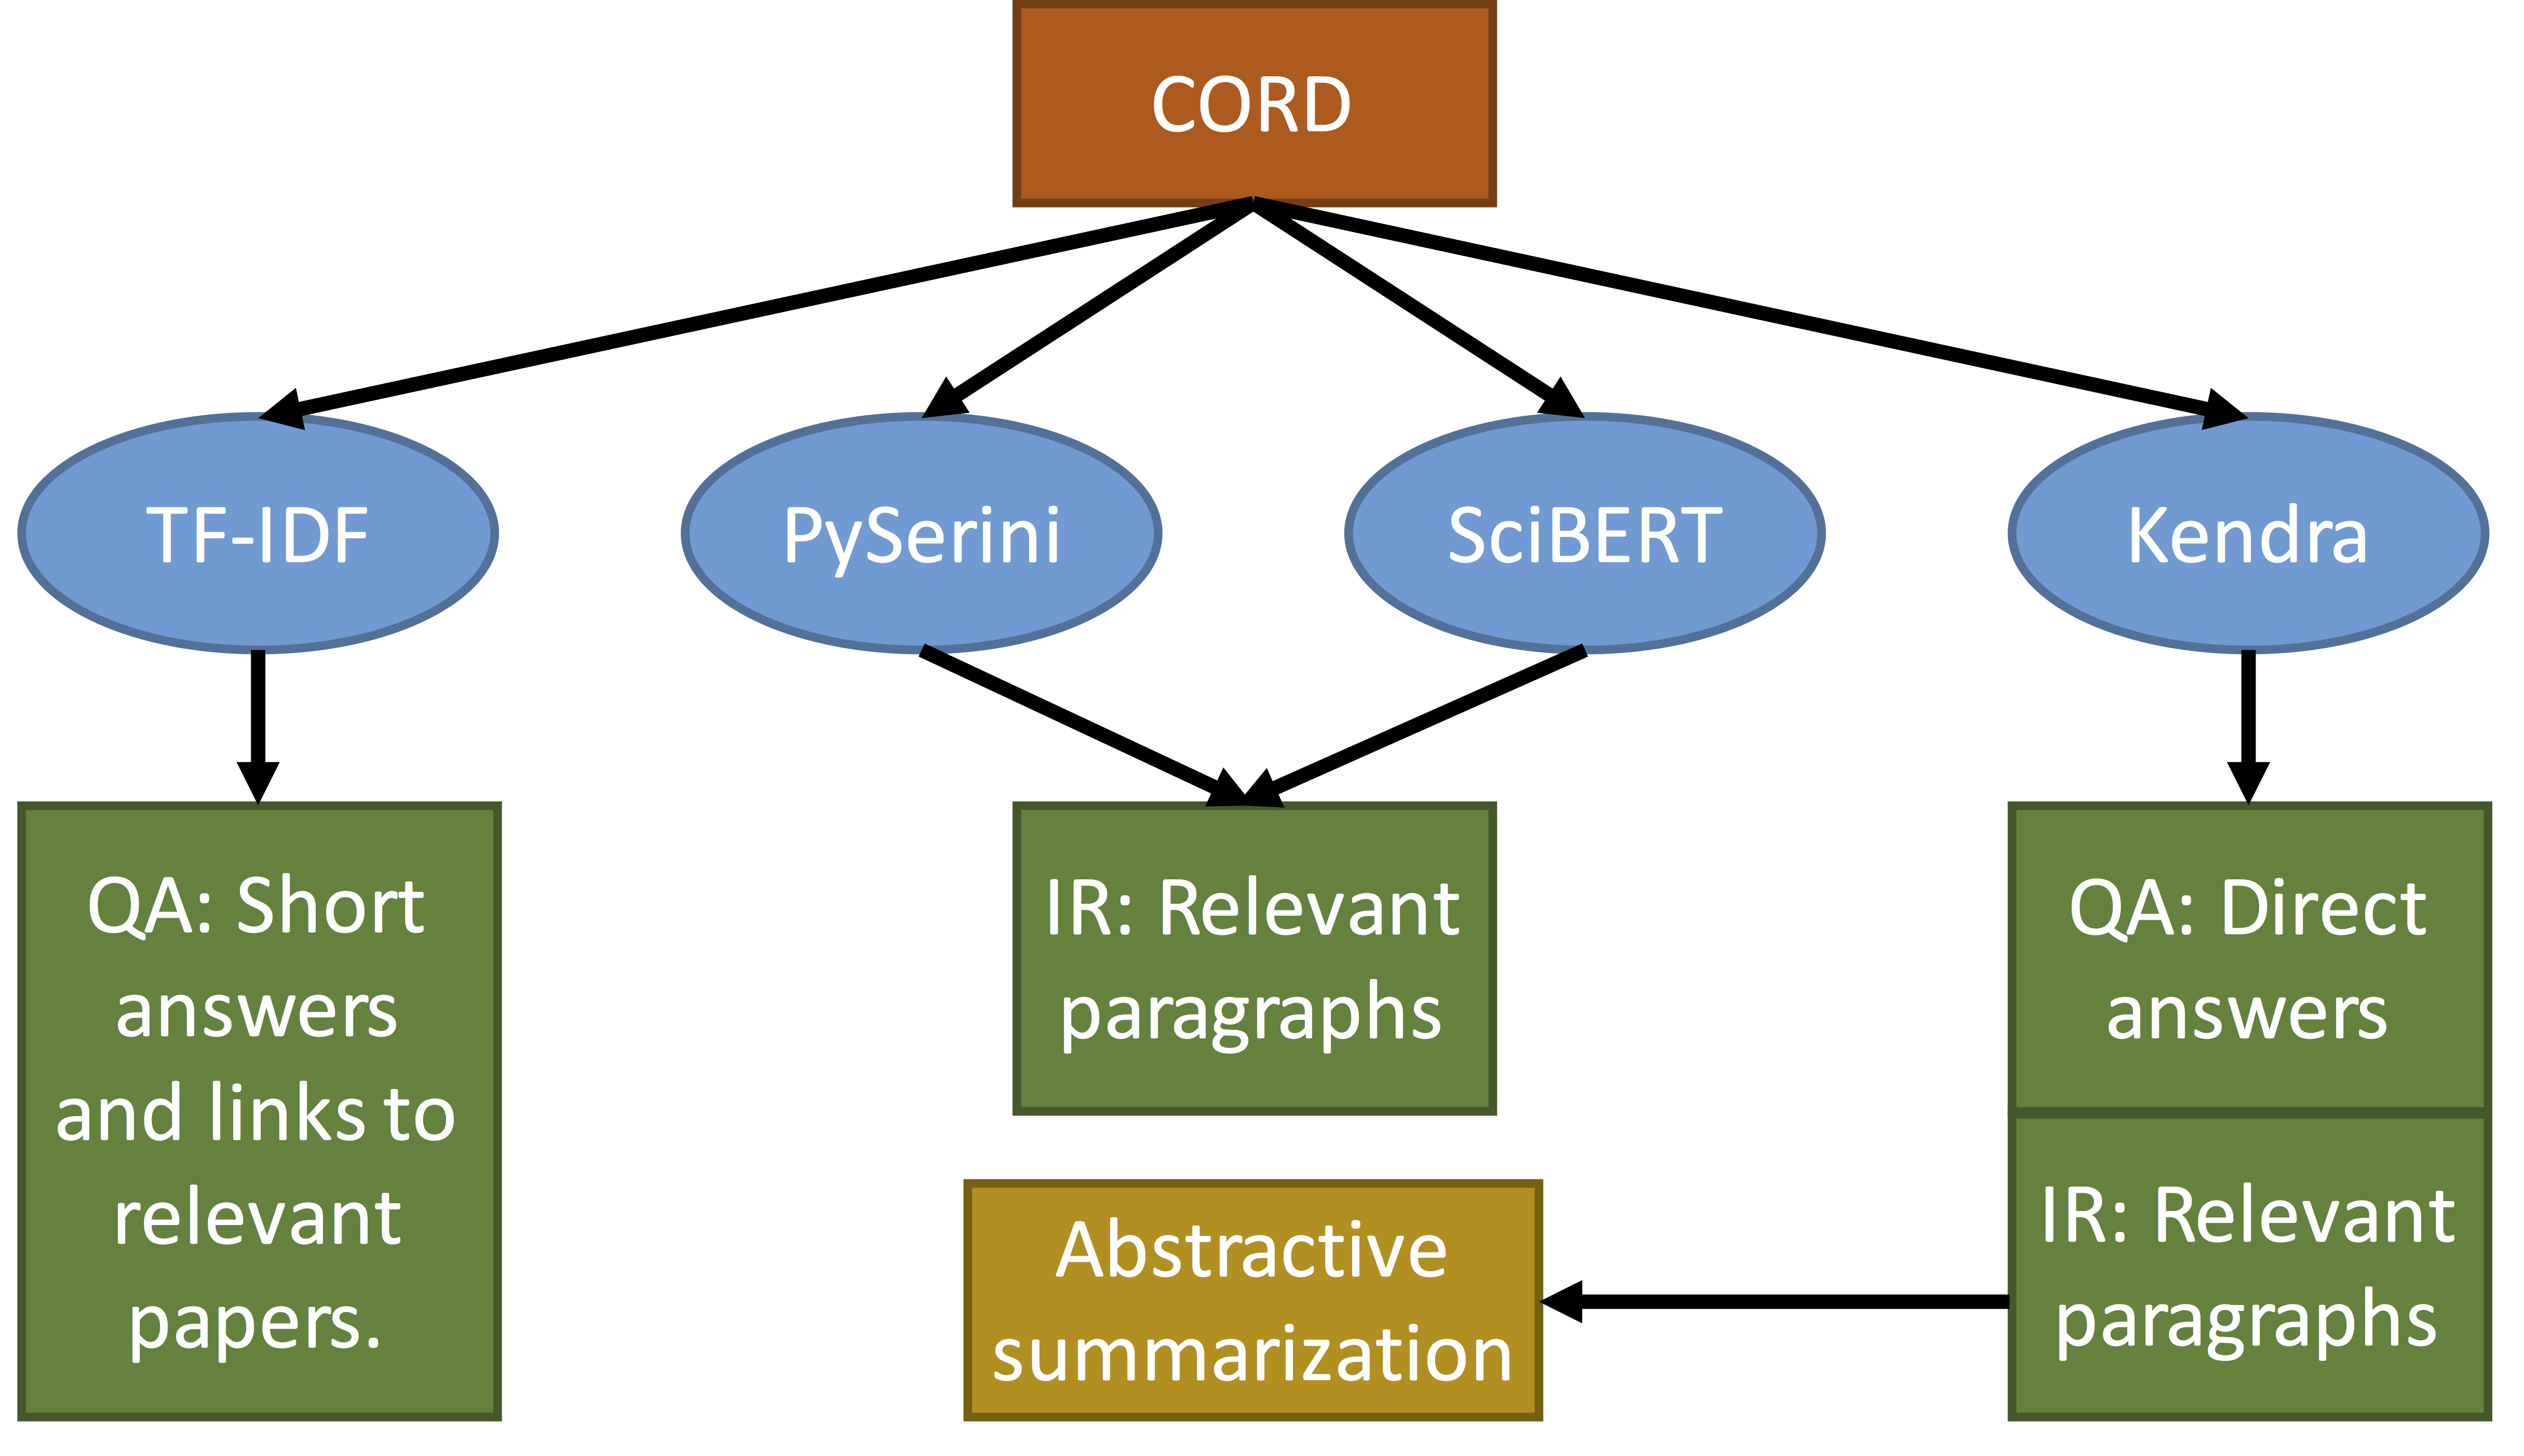 -->
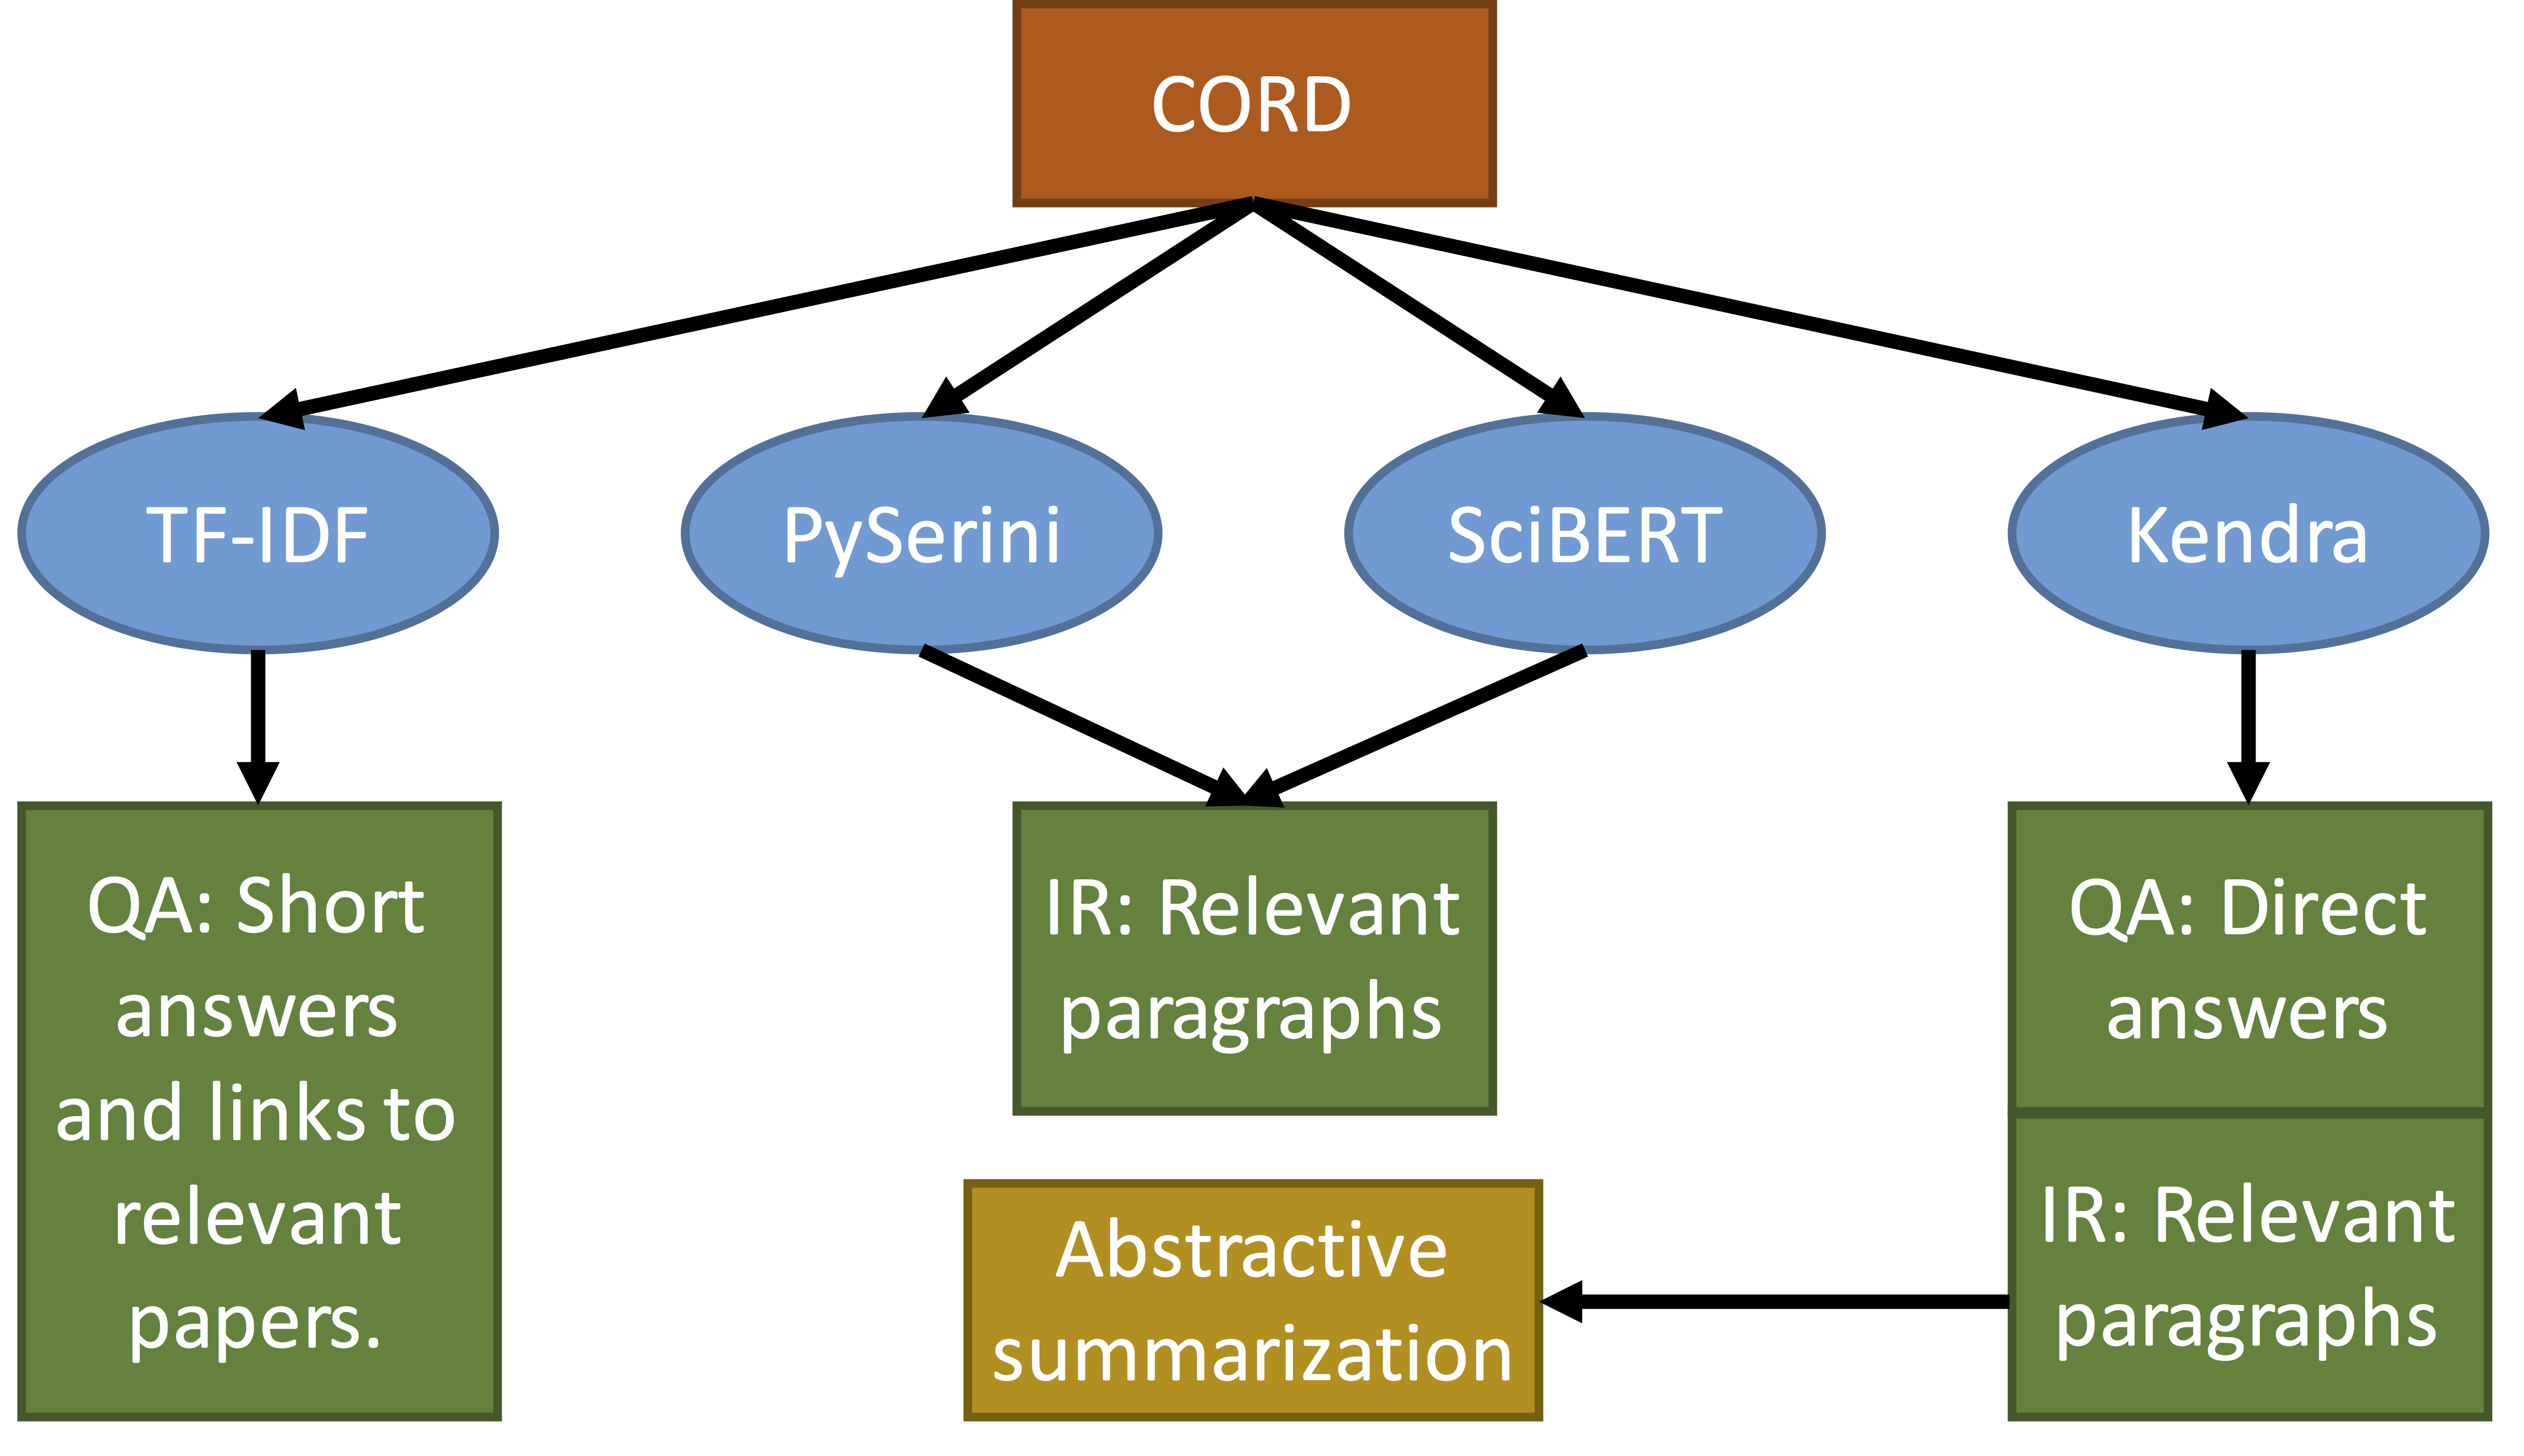

**Figure 1.** Our pipeline for tackling the CORD challenge. Our key contributions are as follows: 1) SciBERT that is finetuned on the CORD dataset; 2) QA using TF-IDF and Kendra; 3) IR usingh PySerini (with our fine-tuned SciBERT) and Kendra; 4) Abstractive summarization of Kendra’s IR using a state-of-the-art SciBERT seq2seq summarization model, trained on scientific articles and their corresponding press releases in Science Daily.

## Finetuning SciBERT. 

We adapted Huggingface’s `run_language_modeling.py` script and fine-tuned SciBERT on the CORD dataset for 950,000 steps.


## Abstractive summarization on Kendra’s IR.

We used a custom dataset consisting of pairs of scientific articles and their corresponding press releases in the media outlet Science Daily (https://www.sciencedaily.com/). We trained a PreSumm model (https://github.com/nlpyang/PreSumm) for abstractive summarization using SciBERT instead of BERT as a base for the seq2seq configuration. Then we performed an out-of-domain experiment, where we took every question from the CORD challenge and appended it to the relevant paragraphs that Kendra extracted. We then used this concatenation as a source for our summarization system to produce a brief abstractive summary for each question. Below we present our initial results: 

## Abstractive summaries for the extracted relevant paragraphs from Kendra.
* Question: what do we know about diagnostics and surveillance ?
  * Summary: it is commonly thought that the flu virus evolves rapidly and is only a small fraction of the population .<q>but why do we know about the virus that is , on a some point to the possibility of finding a whole new vaccine or diagnostic tool for influenza ?
* Question: what has been published about medical care ?
  * Summary: while hospitals and health organizations could focus on helping unravel how sick people feel during their epidemics , there is no ethical benefit , according to a new survey .
* Question: what do we know about diagnostics and surveillance ?
  * Summary: an international group of researchers is developing a way to monitor dangerous infectious diseases before they have been able to diagnose them .
* Question: what is known about transmission , incubation , and environmental stability ?
  * Summary: as the flu continues to spread seasonally , new research shows that even smallpox outbreaks are most likely to follow seasonally in the winter .
* Question: what do we know about diagnostics and surveillance ?
  * Summary: with the help of a handheld diagnostic test , researchers have developed a microfluidic chip that can detect the presence of pathogens in the blood with high resources .<q>the technology could dramatically improve the accuracy of diagnostic tests and help to monitor environmental conditions such as cancer .
* Question: what do we know about vaccines and therapeutics ?
  * Summary: in a new report , scientists have developed a way to identify the targets for potential therapeutics and vaccines for deadly mosquito-borne diseases such as sars , ebola and dengue .
* Question: what has been published about information sharing and inter-sectoral collaboration ?
  * Summary: a new review examines how fast communication works on the public in response to disease outbreaks .<q>the study is the first to consider risks and benefits of communication between vulnerable populations to the emerging infectious disease and its potential to help the public .
* Question: what has been published about information sharing and inter-sectoral collaboration ?
  * Summary: results from a new mathematical model suggest that health insurance coverage in cities is not limited .<q>the study suggests that the majority of cities affected by the 2009-2011 influenza pandemic had good insurance benefits under their health insurance plans or were significantly lower than the average income free .
* Question: what do we know about non-pharmaceutical interventions ?
  * Summary: the mosquito-borne virus that causes ebola hemorrhagic fever could spread to animals and humans , too , according to a new analysis .<q>the study examined the factors that lead to ebola-borne viruses and suggests that even communities with limited social and environmental factors play a role .
* Question: what has been published about information sharing and inter-sectoral collaboration ?
  * Summary: the recent ebola epidemic epidemic epidemic in the u.s. has received an immediate review of the public health information , according to research .<q>the review is a new issue.
* Question: what has been published about information sharing and inter-sectoral collaboration ?
  * Summary: the global action to prevent disease outbreaks in developing countries is vital to public health staff and services , according to a new study .<q>this time-lapse study has assessed how much capitalize on public health education , communication technology , and transmission .

We observe that the summaries are deviating from the topic, In future work we will work on improving these summaries, and fine-tune the summarization system on the CORD dataset instead of performing an out-of-domain experiment without fine-tuning.

---

## Credits:
 * This notebook is based on the one provided by the pyserini team.
 * It is part of a collaborative effort with @atanasova, @charlotteloh, @darumen, @preslav